In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, Dataset
import os
from torchvision import datasets, transforms

C:\Users\Semen\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
train_batch_size=64
test_batch_size=1000
n_epochs = 3
learning_rate=0.01
momentum = 0.5
use_cuda = False
seed = 1
torch.manual_seed(seed)
log_interval = 1000
save_network = True

In [3]:
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_dataset = datasets.MNIST('data', train=True, download=True,
                    transform=transforms.Compose([transforms.ToTensor(),
                                                  transforms.Normalize((0.1307,), (0.3081,))]))

In [4]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
train_dataset.targets.shape

torch.Size([60000])

In [6]:
test_dataset = datasets.MNIST('data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))


In [7]:
test_dataset.data.shape

torch.Size([10000, 28, 28])

In [8]:
test_dataset.targets.shape

torch.Size([10000])

In [9]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [10]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [11]:
train_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [12]:
class NewLabelDataset(Dataset):
    def __init__(self, root_dir, label, transform=None, repeats = 20):
        self.root_dir = root_dir
        self.label = label
        self.transform = transform

        # Получите список всех файлов в директории
        self.file_list = []
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.file_list.append(os.path.join(root, file))
                    
        # Повторите список файлов repeats раз
        self.file_list = self.file_list * repeats

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('L')  # Открыть изображение в оттенках серого

        if self.transform:
            img = self.transform(img)

        label = self.label

        return img, label


In [13]:
transform = transforms.Compose([
    transforms.Resize((28, 28)), transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
])

In [14]:
plus_dataset = NewLabelDataset(root_dir='plusimages', label=10, transform=transform)
plus_loader = torch.utils.data.DataLoader(plus_dataset, batch_size=test_batch_size, shuffle=True)

Размер датасета: 300


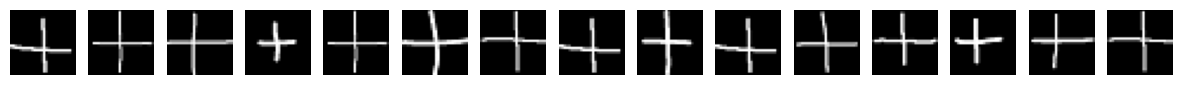

In [15]:
images, labels = next(iter(plus_loader))
print(f'Размер датасета: {len(plus_loader.dataset)}')
fig, axs = plt.subplots(1, 15, figsize=(15, 1))
for i in range(15):
    axs[i].imshow(images[i].squeeze(), cmap='gray')
    axs[i].axis('off')
plt.show()

In [16]:
concated_dataset = ConcatDataset([train_dataset, plus_dataset])

In [17]:
len(concated_dataset)

60300

In [18]:
concated_loader = torch.utils.data.DataLoader(concated_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)

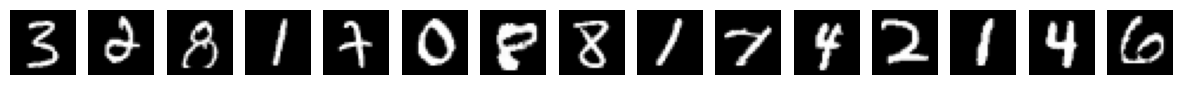

In [19]:
images, labels = next(iter(concated_loader))
fig, axs = plt.subplots(1, 15, figsize=(15, 1))
for i in range(15):
    axs[i].imshow(images[i].squeeze(), cmap='gray')
    axs[i].axis('off')
plt.show()

In [46]:
# We'll use two 2-D convolutional layers followed by two fully-connected (or linear) layers. 
# As activation function we'll choose rectified linear units (ReLUs in short) 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.conv2_drop = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 11)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2_drop(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [35]:
Net()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=11, bias=True)
)

In [36]:
network = Net().to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [37]:
def train(network, device, train_loader, optimizer, n_epochs):
    network.train()
    avg_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # обнуление градиентов всех параметров сети
        output = network(data) # пропускаем данные через сеть для получения предсказаний
        # вычисление потерь между предсказаниями и таргетами с использованием negative log likelihood
        loss = F.nll_loss(output, target) 
        loss.backward() # вычисление градиентов потерь
        optimizer.step() # обновление параметров сети с учетом вычисленных градиентов
        avg_loss+=F.nll_loss(output, target, reduction='sum').item()        
    
    avg_loss/=len(train_loader.dataset)
    print('Train Epoch:{} Average loss = {:.4f}, dataset_size = {} '.format(n_epochs,avg_loss, len(train_loader.dataset)))
    return avg_loss

In [38]:
def test(network, device, loader):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    accuracy = 100. * correct / len(loader.dataset)
    return test_loss,accuracy

In [39]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, **kwargs)

In [40]:
train_losses = []
test_losses = []
accuracy_list = []
for epoch in range(1, n_epochs + 1):
    train_loss = train(network, device, concated_loader, optimizer, epoch)
    test_loss,accuracy = test(network, device, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracy_list.append(accuracy)

Train Epoch:1 Average loss = 0.5431, dataset_size = 60300 

Test set: Average loss: 0.1172, Accuracy: 9647/10000 (96%)

Train Epoch:2 Average loss = 0.1791, dataset_size = 60300 

Test set: Average loss: 0.0709, Accuracy: 9777/10000 (98%)

Train Epoch:3 Average loss = 0.1347, dataset_size = 60300 

Test set: Average loss: 0.0593, Accuracy: 9806/10000 (98%)



In [41]:
test_plus_dataset = NewLabelDataset(root_dir='plusimages', label=10, transform=transform, repeats = 10)
test_plus_loader = torch.utils.data.DataLoader(test_plus_dataset, batch_size=test_batch_size, shuffle=True)

In [42]:
test_loss,accuracy = test(network, device, test_plus_loader)


Test set: Average loss: 0.0626, Accuracy: 150/150 (100%)



In [43]:
concat_test_dataset = ConcatDataset([test_dataset, test_plus_dataset])

In [44]:
test_concat_loader = torch.utils.data.DataLoader(concat_test_dataset, batch_size=test_batch_size, shuffle=True)

In [45]:
test_loss, accuracy = test(network, device, test_concat_loader)


Test set: Average loss: 0.0594, Accuracy: 9956/10150 (98%)



In [32]:
examples = enumerate(test_plus_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([150, 1, 28, 28])

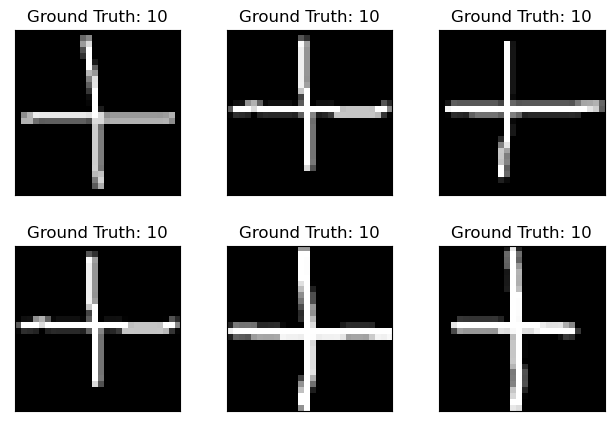

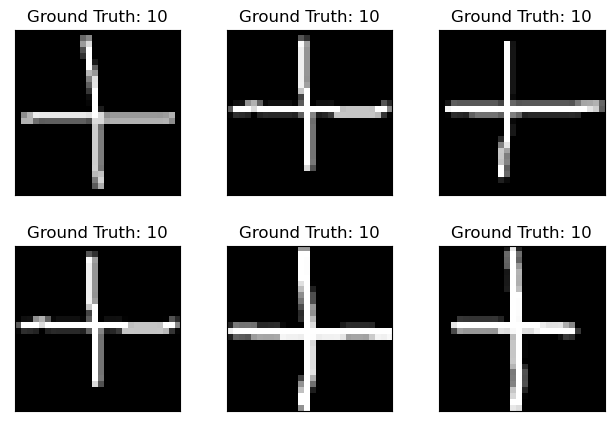

In [33]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

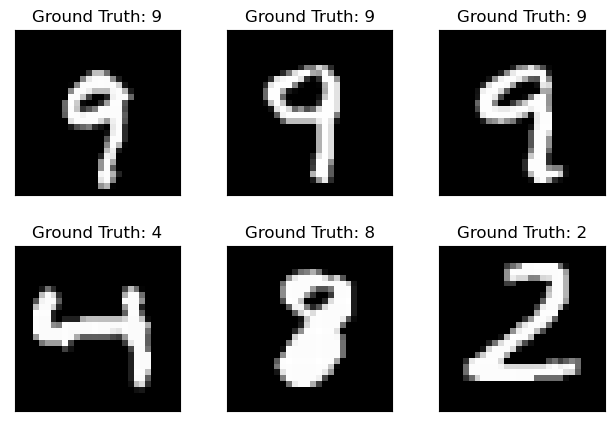

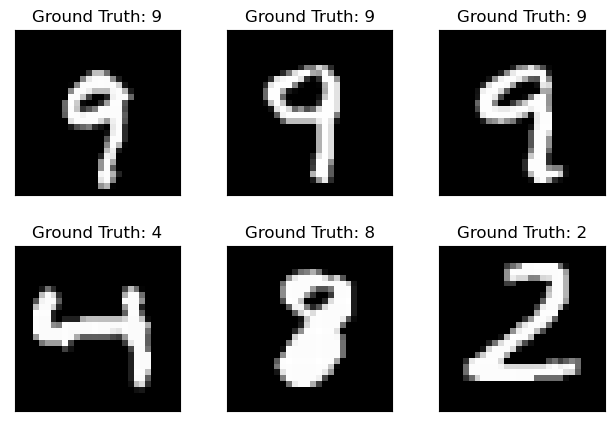

In [197]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig